In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# os.listdir('../input')

# Xploring the files and getting the path

Donlaoding the FIles from Kaggle

In [4]:
!pip install -q kaggle  # Downloading the files from kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kartikpanchal12","key":"26c6e2063ef980f5ab7d734e25f4968c"}'}

In [6]:
# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets list

In [7]:
!kaggle competitions download -c state-farm-distracted-driver-detection
# !kaggle datasets download *url_suffix* -p /content/sample_data/ --unzip

100% 4.00G/4.00G [03:08<00:00, 24.9MB/s]
100% 4.00G/4.00G [03:08<00:00, 22.8MB/s]


Unzipping the File

In [8]:
import zipfile
zip = zipfile.ZipFile("/content/state-farm-distracted-driver-detection.zip")
zip.extractall()
zip.close()

Getting the Paths of the File

In [6]:
from os import listdir
import pandas as pd
import numpy as np
train_path = '/content/imgs/train'

In [7]:
test_path = '/content/imgs/test'

In [8]:
listdir(test_path).__len__()

79726

In [9]:
data = pd.read_csv("/content/driver_imgs_list.csv")
data.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


# Preparing Inputs for Models

In [10]:
from tqdm import tqdm
def loadbatchImages(path):
    cat_list = listdir(path)    # Folder names of diiferent categories like c0,c1,c2....
    loadImages = []
    loadlabels = []
    for cat_folder in cat_list: # Iterating over list of category folders
        img_path = path + "/" + cat_folder  # getting the path of images of particular category folder
        images_list = listdir(img_path)  # Getting the name of images
        for img_name in tqdm(images_list):
            single_image_path = img_path +"/"+ img_name  # Getting the path of single image
            loadImages.append(single_image_path)  # loading the paths of all the images in that category into a list
            loadlabels.append(int(cat_folder[1:])) # loading the category name of that image with only its digits like 0,1,2....
            
    return loadImages,loadlabels

In [11]:
loadImages,loadlabels = loadbatchImages(train_path)

100%|██████████| 2267/2267 [00:00<00:00, 680392.64it/s]


# Getting the number of classes

In [12]:
num_classes = len(np.unique(loadlabels)) # getting the number of classes(categories)

In [13]:
num_classes  # Here we have 10 classes like c0,c1,c2,c3....c9

10

# Here we are doing One Hot Encodings of different categories

In [14]:
from keras.utils.np_utils import to_categorical

labelsHot = to_categorical(loadlabels,num_classes = num_classes) # here we are converting the list into one hot encoding
                                       # like [0,1,2....] => [[1,0,0,0,0,0,0,0,0,0],......] 

# Creating DataFrames for Data Generators

In [15]:
dataset = pd.DataFrame()
dataset["path"] = loadImages
dataset["labels"] = list(labelsHot)

In [16]:
dataset.path[0]

'/content/imgs/train/c7/img_75299.jpg'

# Creating data Generators

In [17]:
from keras.preprocessing.image import ImageDataGenerator
Img_size = (128,128)  # Converting Image size to 128*128 for processing because larger size images cant be process easily
data_gen = ImageDataGenerator(samplewise_center = True,
                              samplewise_std_normalization = True,
                              horizontal_flip = True,
                              vertical_flip = False,
                              height_shift_range = 0.05,
                              width_shift_range = 0.1,
                              rotation_range = 5,
                              shear_range = 0.1,
                              fill_mode = "reflect",
                              zoom_range = 0.15
                             )

In [18]:
import os
def flow_from_dataframe(data_gen,dataset,path_col,y_col,**dataflow_args):
    base_dir = os.path.dirname(dataset[path_col].values[0])
#     print(base_dir)
    print("# Ignore next message from keras,values are replaced anyways")
    
    df_gen = data_gen.flow_from_directory(base_dir,class_mode = "sparse",**dataflow_args)
    
    df_gen.filenames = dataset[path_col].values
    df_gen.classes = np.array([np.argmax(i) for i in dataset[y_col].values])
#     print(type(df_gen.classes))
    df_gen.samples = dataset.shape[0]
    df_gen.n = dataset.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ""  # since we have full path
    df_gen.filepaths.extend(df_gen.filenames.tolist())
#     print(len(df_gen.filepaths))

    print(f"Reinserting dataframe: '{dataset.shape[0]}' images")
    
    return df_gen

In [19]:
from sklearn.model_selection import train_test_split
train_data,test_data = train_test_split(dataset,test_size = 0.25,random_state = 2018)

In [20]:
train_gen = flow_from_dataframe(data_gen,
                                train_data,
                                path_col = "path",
                                y_col = "labels",
                                target_size = Img_size,
                                batch_size = 32)


test_gen = flow_from_dataframe(data_gen,
                               test_data,
                               path_col = "path",
                               y_col = "labels",
                               target_size = Img_size,
                               batch_size = 256
                              ) # we can use larger batches for evaluation because we have larger test images

# Taking a larger slice of images of test just for evaluation of our model
x_test,y_test = flow_from_dataframe(data_gen,
                                    test_data,
                                    path_col = "path",
                                    y_col = "labels",
                                    target_size = Img_size,
                                    batch_size = 2048
                                        ).__next__()
                    

# Ignore next message from keras,values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: '16818' images
# Ignore next message from keras,values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: '5606' images
# Ignore next message from keras,values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: '5606' images


In [21]:
t_x,t_y = next(train_gen)

In [22]:
t_x.shape[1:]

(128, 128, 3)

# Creating Pretrained model VGG16

In [2]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

import keras 
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential,model_from_json,load_model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam, Adagrad,Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
%matplotlib inline

In [24]:
pretrained_model = VGG16(include_top = False,input_shape = t_x.shape[1:])
base_model = pretrained_model # Topless
optimizer1 = Adam()
# Add top layers
x = base_model.output
x = Conv2D(100, kernel_size = (3,3),padding = 'valid')(x)
x = Flatten()(x)
x = Dropout(0.75)(x)
dense_1 = Dense(num_classes,activation = "softmax")(x)
model = Model(inputs = base_model.input,outputs = dense_1)
# Train Top layer
for layer in base_model.layers:
    layer.trainable = False

model.compile(loss = "sparse_categorical_crossentropy",optimizer = optimizer1,metrics =["accuracy"])
model.summary()

58889256/58889256 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                              

In [ ]:
model.fit(train_gen,steps_per_epoch = 100,validation_data = (x_test,y_test),epochs = 10)

In [38]:
model.save("/content/drive/MyDrive/Distracted_Driver_Detection/model.h5")

In [26]:
from glob import glob
test_image_paths = glob("/content/imgs/test/*.jpg",recursive = True)

In [27]:
X_test = pd.DataFrame()
X_test["path"] = test_image_paths

In [28]:
X_test["path"][0]

'/content/imgs/test/img_42382.jpg'

In [29]:
X_test["labels"] = X_test["path"].map(lambda x: os.path.basename(X_test["path"][0]))

In [30]:
X_test.head()

,path,labels
0,/content/imgs/test/img_42382.jpg,img_42382.jpg
1,/content/imgs/test/img_71212.jpg,img_42382.jpg
2,/content/imgs/test/img_50004.jpg,img_42382.jpg
3,/content/imgs/test/img_11432.jpg,img_42382.jpg
4,/content/imgs/test/img_87641.jpg,img_42382.jpg


In [31]:
X_test["labels"].head()

0    img_42382.jpg
1    img_42382.jpg
2    img_42382.jpg
3    img_42382.jpg
4    img_42382.jpg
Name: labels, dtype: object

In [32]:
test_gen = flow_from_dataframe(data_gen,X_test,path_col = "path",y_col = "labels",target_size = Img_size,batch_size = 256)

# Ignore next message from keras,values are replaced anyways
Found 0 images belonging to 0 classes.
Reinserting dataframe: '79726' images


In [33]:
pred = model.predict(test_gen,verbose = 1)

312/312 [==============================] - 736s 2s/step


In [39]:
pred[:3]

array([[1.7367346e-02, 2.9555906e-06, 3.9777988e-05, 7.3445966e-07,
        1.2028665e-05, 1.7389148e-02, 4.7185097e-08, 5.4817450e-05,
        4.0153350e-06, 9.6512914e-01],
       [6.9346257e-10, 4.1539250e-05, 1.0568917e-03, 3.2833075e-08,
        2.1787699e-07, 7.6759310e-10, 9.9849927e-01, 8.6111959e-07,
        4.0123213e-04, 5.2287059e-09],
       [9.4032247e-04, 2.6514843e-05, 4.2837883e-07, 9.8708147e-01,
        1.0858920e-02, 1.3768116e-04, 1.1762994e-09, 8.0154642e-08,
        1.1015296e-05, 9.4348798e-04]], dtype=float32)

In [40]:
def do_clip(pred,mx):
    return np.clip(pred,a_min = (1-mx)/9, a_max = mx)

In [41]:
pred = do_clip(pred,0.93)

In [42]:
pred[:3]

array([[0.01736735, 0.00777778, 0.00777778, 0.00777778, 0.00777778,
        0.01738915, 0.00777778, 0.00777778, 0.00777778, 0.93      ],
       [0.00777778, 0.00777778, 0.00777778, 0.00777778, 0.00777778,
        0.00777778, 0.93      , 0.00777778, 0.00777778, 0.00777778],
       [0.00777778, 0.00777778, 0.00777778, 0.93      , 0.01085892,
        0.00777778, 0.00777778, 0.00777778, 0.00777778, 0.00777778]],
      dtype=float32)

In [43]:
pred.shape

(79726, 10)

In [44]:
X_test["labels"][:3]

0    img_42382.jpg
1    img_42382.jpg
2    img_42382.jpg
Name: labels, dtype: object

In [45]:
submission = pd.DataFrame()
submission["img"] = X_test["labels"]

submission["c0"] = pred[:,0]
submission["c1"] = pred[:,1]
submission["c2"] = pred[:,2]
submission["c3"] = pred[:,3]
submission["c4"] = pred[:,4]
submission["c5"] = pred[:,5]
submission["c6"] = pred[:,6]
submission["c7"] = pred[:,7]
submission["c8"] = pred[:,8]
submission["c9"] = pred[:,9]

In [ ]:
submission.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_96590.jpg,0.020559,0.007778,0.007778,0.335404,0.342313,0.007778,0.007778,0.007778,0.007778,0.300499
1,img_96590.jpg,0.007778,0.007778,0.007778,0.007778,0.930000,0.007778,0.007778,0.007778,0.007778,0.007778
2,img_96590.jpg,0.007778,0.007778,0.007778,0.007778,0.013049,0.007778,0.704885,0.221488,0.060294,0.007778
3,img_96590.jpg,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.025985,0.930000,0.007778
4,img_96590.jpg,0.930000,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.007778,0.027243


In [ ]:
# submission.to_csv("submission_1.csv",index = False)

In [3]:
model = load_model("/content/drive/MyDrive/Distracted_Driver_Detection/model.h5") # Loading the model

Preparing code for making WebApplication

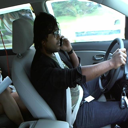

In [28]:
from PIL import Image
img = Image.open("/content/imgs/test/img_100007.jpg")
img = img.resize((128,128))
img

In [29]:
import numpy as np
img = np.array(img)

In [30]:
img = np.expand_dims(img,axis = 0)

In [31]:
model.predict(img)

1/1 [==============================] - 0s 16ms/step


array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 2.3282269e-32,
        1.0000000e+00, 0.0000000e+00, 6.6790234e-37, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)